In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import math
import pprint
from sklearn import preprocessing
import re

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
nltk.download('punkt')
from nltk import word_tokenize

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mattcirelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
# Update SIA with Loughran McDonald Dictionary

import csv
import pandas as pd

# stock market lexicon
stock_lex = pd.read_csv('stock_lex.csv')

stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

#update the positive and negative dictionaries
positive = []
reader = csv.reader('lm_positive.csv')
for row in reader:
    positive.append(row[0].strip())
    
negative = []
reader = csv.reader('lm_negative.csv')
for row in reader:
    entry = row[0].strip().split(" ")
    if len(entry) > 1:
        negative.extend(entry)
    else:
        negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [70]:
data = pd.read_csv('XOM_news.csv')

In [71]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
0,0,NaN,nws_JbvxWa,2019-08-07 23:00:00+00:00,"TOKYO/SINGAPORE, Aug 7 (Reuters) - An inexorab...",RPT-Japan LNG buyers talk tough as spot prices...,https://finance.yahoo.com/news/rpt-japan-lng-b...
1,1,NaN,nws_PQOxJP,2019-08-07 23:00:00+00:00,"Markets took a beating this week, with a numbe...",The Worst Is Still To Come In Energy Markets,https://finance.yahoo.com/news/worst-still-com...
2,2,NaN,nws_KkLDpo,2019-08-07 20:12:27+00:00,"After opening lower in dramatic fashion, stock...",Dow Jones Today: Sliding Bond Yields Lift Divi...,https://finance.yahoo.com/news/dow-jones-today...
3,3,NaN,nws_GrjbeV,2019-08-07 17:52:05+00:00,Style Box ETF report for IWX,Should iShares Russell Top 200 Value ETF (IWX)...,https://finance.yahoo.com/news/ishares-russell...
4,4,NaN,nws_035E9w,2019-08-07 15:19:03+00:00,"Integrated majors ExxonMobil (XOM), Chevron (C...","Oil & Gas Stock Roundup: Exxon, Chevron, Shell...",https://finance.yahoo.com/news/oil-gas-stock-r...


In [72]:
data['publication_date']=pd.to_datetime(data.publication_date,format='%Y-%m-%d')
data.index =data['publication_date']


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12846 entries, 2019-08-07 23:00:00 to 2015-04-08 20:21:06
Data columns (total 7 columns):
Unnamed: 0          12846 non-null int64
company             0 non-null float64
id                  12846 non-null object
publication_date    12846 non-null datetime64[ns]
summary             12844 non-null object
title               12846 non-null object
url                 12846 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 802.9+ KB


In [74]:
data.head()

,Unnamed: 0,company,id,publication_date,summary,title,url
publication_date,,,,,,,
2019-08-07 23:00:00,0,NaN,nws_JbvxWa,2019-08-07 23:00:00,"TOKYO/SINGAPORE, Aug 7 (Reuters) - An inexorab...",RPT-Japan LNG buyers talk tough as spot prices...,https://finance.yahoo.com/news/rpt-japan-lng-b...
2019-08-07 23:00:00,1,NaN,nws_PQOxJP,2019-08-07 23:00:00,"Markets took a beating this week, with a numbe...",The Worst Is Still To Come In Energy Markets,https://finance.yahoo.com/news/worst-still-com...
2019-08-07 20:12:27,2,NaN,nws_KkLDpo,2019-08-07 20:12:27,"After opening lower in dramatic fashion, stock...",Dow Jones Today: Sliding Bond Yields Lift Divi...,https://finance.yahoo.com/news/dow-jones-today...
2019-08-07 17:52:05,3,NaN,nws_GrjbeV,2019-08-07 17:52:05,Style Box ETF report for IWX,Should iShares Russell Top 200 Value ETF (IWX)...,https://finance.yahoo.com/news/ishares-russell...
2019-08-07 15:19:03,4,NaN,nws_035E9w,2019-08-07 15:19:03,"Integrated majors ExxonMobil (XOM), Chevron (C...","Oil & Gas Stock Roundup: Exxon, Chevron, Shell...",https://finance.yahoo.com/news/oil-gas-stock-r...


In [75]:
str(data["summary"])

"publication_date\n2019-08-07 23:00:00    TOKYO/SINGAPORE, Aug 7 (Reuters) - An inexorab...\n2019-08-07 23:00:00    Markets took a beating this week, with a numbe...\n2019-08-07 20:12:27    After opening lower in dramatic fashion, stock...\n2019-08-07 17:52:05                         Style Box ETF report for IWX\n2019-08-07 15:19:03    Integrated majors ExxonMobil (XOM), Chevron (C...\n2019-08-07 08:20:58    TOKYO/SINGAPORE, Aug 7 (Reuters) - An inexorab...\n2019-08-07 04:01:13    (Bloomberg Markets) -- Earlier this year, one ...\n2019-08-06 23:00:00    The oil majors posted mixed results when they ...\n2019-08-06 16:27:34    Energy sector players ExxonMobil, Chevron, Roy...\n2019-08-06 14:14:33    (Bloomberg Opinion) -- So, energy investors, t...\n2019-08-06 14:06:52    Top Energy Stocks Top Energy Stocks XOM 0 57 X...\n2019-08-06 14:06:52    Top Energy Stocks Top Energy Stocks XOM 0 57 X...\n2019-08-06 11:52:08    Energy sector stocks including ExxonMobil (XOM...\n2019-08-06 11:49:05

In [76]:
#drop any duplicated headlines
data = data.sort_values(['summary']).drop_duplicates(subset='title')
data = data.sort_values(['publication_date'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'publication_date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
# Concatenate all news into one
#data["summary"] = data.filter(regex=("Top.*")).apply(lambda x: ''.join(str(x.values)), axis=1)

In [78]:
#Tokenize Words Data 
text=data["summary"][1]
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['Exclusive', '-', 'Anadarko', 'considers', 'selling', 'Mozambique', 'gas', 'assets', 'to', 'Exxon']


In [79]:
##Tokenize Sentences Data
from nltk.tokenize import sent_tokenize
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['Exclusive - Anadarko considers selling Mozambique gas assets to Exxon']


In [80]:
#Import English Stopwords
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'or', "needn't", 'mustn', 'themselves', 'only', 'you', 'have', 'this', 'other', "doesn't", 'me', 'while', "didn't", 'through', 'aren', 'than', "you've", 'whom', 'out', 'with', 'himself', 'what', 'our', "wasn't", 'own', 'doesn', 'too', 'for', 'their', 'just', "mightn't", 'mightn', 'any', 'a', 'above', 'we', 'off', "that'll", 'all', 'that', "you're", 'down', "won't", 'then', 'hers', 'they', 'up', 'yourself', 'few', "aren't", 'it', 'again', 'yourselves', 'i', 'and', "haven't", "don't", 'wouldn', 'has', 'why', 'my', 'being', 'll', 'didn', "you'd", 'am', 'will', 'not', "you'll", 'very', 'below', 'same', 'those', 'an', 'such', 'more', 'wasn', 'he', 'him', 'there', "hadn't", 'theirs', 'won', 'the', "weren't", 'as', 'these', 'when', 't', 'were', 'but', "mustn't", 'his', 'during', 'them', 'couldn', 'o', 'itself', 'both', 'if', 'can', 'doing', 'her', 'now', "shan't", 'do', "isn't", 'herself', 'on', "wouldn't", 're', 'nor', 'having', 'about', 'needn', 'is', 'hadn', 'because', 'haven', 'had', 'wh

In [81]:
#Filter Stopwords
filtered_sent=[]
for w in tokenized_text:
    if w not in stop_words:
        filtered_sent.append(w)
print("Tokenized Sentence:",tokenized_text)
print("Filterd Sentence:",filtered_sent)

Tokenized Sentence: ['Exclusive - Anadarko considers selling Mozambique gas assets to Exxon']
Filterd Sentence: ['Exclusive - Anadarko considers selling Mozambique gas assets to Exxon']


https://github.com/Currie32/Predicting-the-Dow-Jones-with-Headlines/blob/master/Predict_Dow_with_News.ipynb
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

# Clean the headlines
clean_headlines = []

for daily_headlines in data["summary"]:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [82]:
str(data["title"])

"publication_date\n2015-04-08 20:21:06    Analysis - Shell's BG purchase could be cataly...\n2015-04-17 21:57:33    Exclusive - Anadarko considers selling Mozambi...\n2015-07-31 23:12:49    Tumbling oil prices slam profit at Exxon Mobil...\n2015-10-30 18:15:02    Exxon 3rd-qtr profit falls 47 pct but beats ex...\n2016-02-02 20:20:41    Exxon, tops in stock buybacks, now saving its ...\n2016-02-07 08:14:33    As Big Oil shrinks, boards plot different path...\n2016-03-23 21:32:04    Exclusive - Exxon Mobil must allow climate cha...\n2016-04-29 12:09:44    Exxon Mobil first-quarter profit drops 63 percent\n2016-06-23 16:07:44    California pipeline leaks 700 barrels of oil -...\n2016-06-23 18:34:49    Aera Energy says it was not owner of spilled C...\n2016-06-24 12:49:56     Netherlands to cut more Groningen gas production\n2016-06-24 13:05:21    Dutch lower Groningen gas production cap to 24...\n2016-06-27 14:11:32    Engie says would have to shut output at Norway...\n2016-06-29 11:32:02

In [83]:
print(data["summary"])

publication_date
2015-04-08 20:21:06    Analysis - Shell's BG purchase could be cataly...
2015-04-17 21:57:33    Exclusive - Anadarko considers selling Mozambi...
2015-07-31 23:12:49    Tumbling oil prices slam profit at Exxon Mobil...
2015-10-30 18:15:02    Exxon 3rd-qtr profit falls 47 pct but beats ex...
2016-02-02 20:20:41    Exxon, tops in stock buybacks, now saving its ...
2016-02-07 08:14:33    As Big Oil shrinks, boards plot different path...
2016-03-23 21:32:04    Exclusive - Exxon Mobil must allow climate cha...
2016-04-29 12:09:44    Exxon Mobil first-quarter profit drops 63 percent
2016-06-23 16:07:44    California pipeline leaks 700 barrels of oil -...
2016-06-23 18:34:49    Aera Energy says it was not owner of spilled C...
2016-06-24 12:49:56     Netherlands to cut more Groningen gas production
2016-06-24 13:05:21    Dutch lower Groningen gas production cap to 24...
2016-06-27 14:11:32    Engie says would have to shut output at Norway...
2016-06-29 11:32:02    Indonesia's

### SIA compound score Calculation 
https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/


In [84]:
sia = SIA()
results = []

for line in data["title"]:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

print(results[:3])

[{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0, 'headline': "Analysis - Shell's BG purchase could be catalyst needed for U.S. shale deals"}, {'neg': 0.0, 'neu': 0.686, 'pos': 0.314, 'compound': 0.296, 'headline': 'Exclusive - Anadarko considers selling Mozambique gas assets to Exxon'}, {'neg': 0.208, 'neu': 0.56, 'pos': 0.232, 'compound': 0.0772, 'headline': 'Tumbling oil prices slam profit at Exxon Mobil, Chevron'}]


In [85]:
df123 = pd.DataFrame(results)
#df123['publication_date'] = data['publication_date']
#df123.Date = pd.to_datetime(df123.publication_date)
#df123.set_index('publication_date', inplace=True)
df123.head()

,compound,headline,neg,neu,pos
0,0.0000,Analysis - Shell's BG purchase could be cataly...,0.000,1.000,0.000
1,0.2960,Exclusive - Anadarko considers selling Mozambi...,0.000,0.686,0.314
2,0.0772,Tumbling oil prices slam profit at Exxon Mobil...,0.208,0.560,0.232
3,0.2382,Exxon 3rd-qtr profit falls 47 pct but beats ex...,0.000,0.804,0.196
4,0.5106,"Exxon, tops in stock buybacks, now saving its ...",0.000,0.708,0.292


In [86]:
print(df123['headline'][1])

Exclusive - Anadarko considers selling Mozambique gas assets to Exxon


In [87]:
df123.describe()

,compound,neg,neu,pos
count,9835.000000,9835.000000,9835.000000,9835.000000
mean,0.064159,0.058116,0.839990,0.101895
std,0.301198,0.116882,0.167725,0.139585
min,-0.927400,0.000000,0.128000,0.000000
25%,0.000000,0.000000,0.721000,0.000000
50%,0.000000,0.000000,0.846000,0.000000
75%,0.273200,0.000000,1.000000,0.204000
max,0.888500,0.808000,1.000000,0.872000


In [88]:
df123.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 5 columns):
compound    9835 non-null float64
headline    9835 non-null object
neg         9835 non-null float64
neu         9835 non-null float64
pos         9835 non-null float64
dtypes: float64(4), object(1)
memory usage: 384.3+ KB


In [89]:
df123['label'] = 0
df123.loc[df123['compound'] > 0.1, 'label'] = 1
df123.loc[df123['compound'] < -0.1, 'label'] = -1
df123.head()

,compound,headline,neg,neu,pos,label
0,0.0000,Analysis - Shell's BG purchase could be cataly...,0.000,1.000,0.000,0
1,0.2960,Exclusive - Anadarko considers selling Mozambi...,0.000,0.686,0.314,1
2,0.0772,Tumbling oil prices slam profit at Exxon Mobil...,0.208,0.560,0.232,0
3,0.2382,Exxon 3rd-qtr profit falls 47 pct but beats ex...,0.000,0.804,0.196,1
4,0.5106,"Exxon, tops in stock buybacks, now saving its ...",0.000,0.708,0.292,1


In [90]:
print("Positive headlines:\n")
print(list(df123[df123['label'] == 1].headline)[:5])


Positive headlines:

['Exclusive - Anadarko considers selling Mozambique gas assets to Exxon', 'Exxon 3rd-qtr profit falls 47 pct but beats expectations', 'Exxon, tops in stock buybacks, now saving its cash', 'Exclusive - Exxon Mobil must allow climate change vote: SEC', 'Exxon Mobil first-quarter profit drops 63 percent']


In [91]:
print("\nNegative headlines:\n")
print(list(df123[df123['label'] == -1].headline)[:5])


Negative headlines:

['As Big Oil shrinks, boards plot different paths out of crisis', 'California pipeline leaks 700 barrels of oil - fire department', 'Netherlands to cut more Groningen gas production', 'Dutch lower Groningen gas production cap to 24 bcm', "Engie says would have to shut output at Norway's Gjoea field if strike goes ahead"]


In [92]:
print(df123.label.value_counts())

print(df123.label.value_counts(normalize=True) * 100)

 0    4570
 1    3464
-1    1801
Name: label, dtype: int64
 0    46.466701
 1    35.221149
-1    18.312150
Name: label, dtype: float64


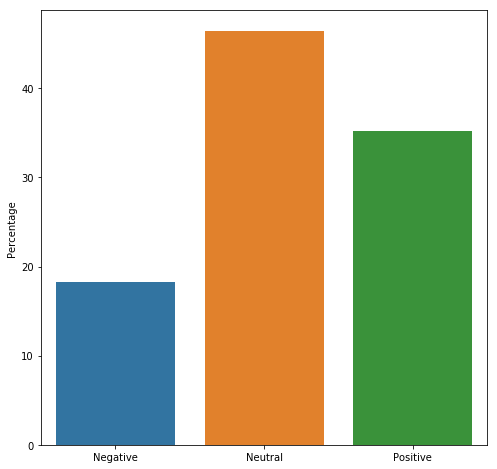

In [93]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))

counts = df123.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Count')

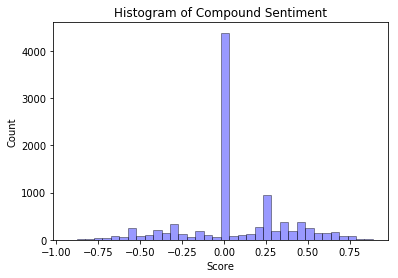

In [94]:

# seaborn histogram
sns.distplot(df123['compound'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Compound Sentiment')
plt.xlabel('Score')
plt.ylabel('Count')

In [95]:
#https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Generating%20Different%20Models.ipynb
#import numpy as np
#import pandas as pd
#from nltk.classify import NaiveBayesClassifier
#from nltk.corpus import subjectivity
#from nltk.sentiment import SentimentAnalyzer
#from nltk.sentiment.util import *
#import nltk
#nltk.downloader.download('vader_lexicon')

#sentence = 'paris shootout police officer suspected guman dead'
#from nltk.sentiment.vader import SentimentIntensityAnalyzer
#import unicodedata
#sid = SentimentIntensityAnalyzer()
#ss = sid.polarity_scores(sentence)
#ss

In [96]:
df123.index =data['publication_date']
df123.head()

,compound,headline,neg,neu,pos,label
publication_date,,,,,,
2015-04-08 20:21:06,0.0000,Analysis - Shell's BG purchase could be cataly...,0.000,1.000,0.000,0
2015-04-17 21:57:33,0.2960,Exclusive - Anadarko considers selling Mozambi...,0.000,0.686,0.314,1
2015-07-31 23:12:49,0.0772,Tumbling oil prices slam profit at Exxon Mobil...,0.208,0.560,0.232,0
2015-10-30 18:15:02,0.2382,Exxon 3rd-qtr profit falls 47 pct but beats ex...,0.000,0.804,0.196,1
2016-02-02 20:20:41,0.5106,"Exxon, tops in stock buybacks, now saving its ...",0.000,0.708,0.292,1


In [97]:
df123.to_csv('XOM_sent_news.csv')